In [2]:
%pip install -r requirements.txt
#%pip uninstall -y tinarm
%pip install -e ../.


Note: you may need to restart the kernel to use updated packages.
Obtaining file:///home/mjfwest/repositories/Lonely-Tool-Cult/tinarm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tinarm (pyproject.toml) ... done
  Created wheel for tinarm: filename=tinarm-0.1-0.editable-py3-none-any.whl size=3547 sha256=4bec8e424865bd935d69ef151c73539ec688dd992b9f39127d57b52f780e7f4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0145od4/wheels/c8/ba/3d/55d5319b8492cf184b68a52db71416b190659ad76ff43a98ab
Successfully built tinarm
  Attempting uninstall: tinarm
    Found existing installation: tinarm 0.1
    Uninstalling tinarm-0.1:
      Successfully uninstalled tinarm-0.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pint_pandas
import logging
import tinarm
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [4]:
### Configure Logging
LOGGING_LEVEL = logging.INFO

logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-03-19 19:02:31,307 - NoJobId - INFO - Kebnekaise - 194884122.py-><module>() - tinarm version 0.1
2024-03-19 19:02:31,308 - NoJobId - INFO - Kebnekaise - 194884122.py-><module>() - pint_pandas version 0.5


In [5]:
# Get the operating points for the machine machine='M1'
# Each opperating point is a folder in the machine folder
machine = 'M1'
operating_points = [op_point for op_point in os.listdir(machine) if os.path.isdir(os.path.join(machine, op_point)) and not op_point.startswith('__pycache__')]

In [6]:
operating_points


['NominalPowerMaxSpeed_13Nm_3600rpm',
 'PeakTorqueBaseSpeed_36Nm_1380rpm',
 'Nominal_24Nm_2060rpm']

In [7]:
# check that we have all the expected charts
def check_charts(machine, operating_points):
    expected_charts = ['BackEmf.csv', 'CurrentAngle.csv',
                    'IronLoss.csv', 'MagnetLoss.csv',
                    'PhaseVoltage.csv', 'Torque.csv']
    for op_point in operating_points:
        print(f"Processing {op_point}")
        charts = [c for c in os.listdir(os.path.join(machine, op_point)) if c.endswith('.csv')]
        charts.sort()

        for chart in charts:
            if chart in expected_charts:
                # in green text
                print(f"\033[32m  {chart} found\033[0m")
            else:
                # in red text
                print(f"\033[31m  {chart} not found\033[0m")
        if "operating_point.py" in os.listdir(os.path.join(machine, op_point)):
            print(f"\033[32m  operating_point.py found\033[0m")
        else:
            print(f"\033[31m  operating_point.py not found\033[0m")
    return charts

charts = check_charts(machine, operating_points)



Processing NominalPowerMaxSpeed_13Nm_3600rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py not found
Processing PeakTorqueBaseSpeed_36Nm_1380rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py not found
Processing Nominal_24Nm_2060rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py found


In [8]:
from M1 import machine as m
from M1.Nominal_24Nm_2060rpm import operating_point as nominal_op



op_point = "Nominal_24Nm_2060rpm"
chart = "BackEmf.csv"
df = pd.read_csv(os.path.join(machine, op_point, chart), index_col=None, header=[0,1])

num_phases = m.winding_parameters["number_phases"].to_base_units().magnitude
num_pole_pairs = (m.rotor_parameters["number_poles"]//2).to_base_units().magnitude


In [9]:
def overlay_emf(df, num_phases, num_pole_pairs):
    assert num_phases == 3
    theta_m = np.hstack((np.deg2rad(df['EMFa']['X'] ),
            np.deg2rad((df['EMFb']['X']-(360/num_pole_pairs/num_phases))),
            np.deg2rad((df['EMFc']['X']+(360/num_pole_pairs/num_phases)))))


    v_emf = np.hstack((df['EMFa']['Y'],
                df['EMFb']['Y'],
                df['EMFc']['Y']))

    not_nan  = np.logical_not(np.logical_and(np.isnan(theta_m), np.isnan(v_emf)))
    theta_m = theta_m[not_nan]
    v_emf = v_emf[not_nan]
    sort_idx = np.argsort(theta_m)
    return theta_m[sort_idx], v_emf[sort_idx]

In [10]:
# set the initial guess, coef[0] is the phase offset, the rest are the cosine coefficients
coefs = np.array([np.nan,  np.nan, np.nan, np.nan,
       -9.96330324e-02, -1.11853145e+00, -2.27614394e-01,  2.32197231e-01,
        2.34067377e-01,  5.18779813e-01,  5.52624693e-02, 0, 0 ])
# make odd coefficients, from 1 to 2*len(coefs)-1
n_idx = np.arange(1, 2*len(coefs)-1, 2)

In [11]:
def predict(coefs, theta, num_pole_pairs=5):
    n_idx = np.arange(1, 2*len(coefs)-1, 2)
    pred = np.matmul(coefs[1:], np.cos(np.outer(n_idx, coefs[0] + theta * num_pole_pairs)))
    return pred

def loss(coefs, theta, v_emf):
    pred = predict(coefs, theta)
    return np.sum((v_emf - pred)**2)

In [12]:
#optimise the coefficients
theta_m, v_emf = overlay_emf(df, num_phases, num_pole_pairs)
peak_voltage = np.max(v_emf)
#set bounds that the coefficients must be positive
bounds = [(None, None) for _ in range(len(coefs))]
bounds[0] = (0, 2*np.pi/num_pole_pairs)
bounds[1] = (peak_voltage, peak_voltage * 1.5) # fundamental
bounds[2] = (-0.1 * peak_voltage , 0)
bounds[3] = (-0.02 * peak_voltage , 0)

coefs[0:4] =np.mean(bounds[0:4], axis=1)
coefs

array([ 6.28318531e-01,  1.93421425e+02, -7.73685700e+00, -1.54737140e+00,
       -9.96330324e-02, -1.11853145e+00, -2.27614394e-01,  2.32197231e-01,
        2.34067377e-01,  5.18779813e-01,  5.52624693e-02,  0.00000000e+00,
        0.00000000e+00])

In [13]:
theta_m, v_emf = overlay_emf(df, num_phases, num_pole_pairs)
res = minimize(loss, coefs,
               args=(theta_m, v_emf),
               method='Nelder-Mead', tol=1e-6,
               bounds=bounds,
               options={'disp': True, "maxiter":9000})
print(res.success)

pred = predict(res.x, theta_m)


Optimization terminated successfully.
         Current function value: 295.510873
         Iterations: 4888
         Function evaluations: 6634
True


In [14]:
phase_emf_a = -res.x[0]/num_pole_pairs
phase_emf_b = -res.x[0]/num_pole_pairs +(2*np.pi / num_pole_pairs / num_phases)
phase_emf_c = -res.x[0]/num_pole_pairs +2*(2*np.pi / num_pole_pairs / num_phases)


In [15]:
from phase_a_emf import phase_a_emf
phase_a_emf(0)

array([270.01055664])

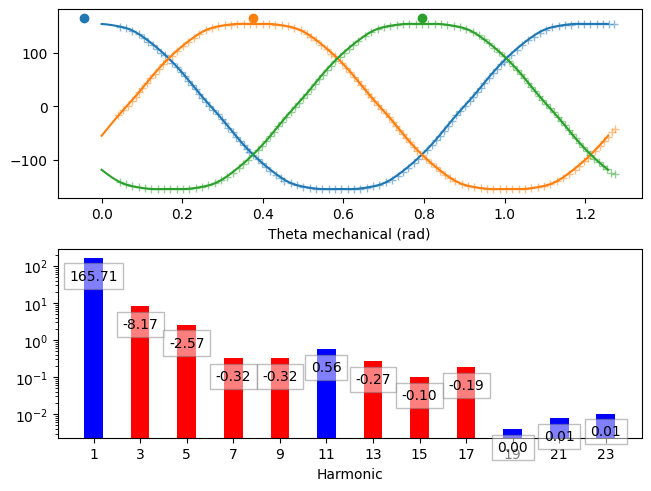

In [16]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
la, = ax_t.plot(np.deg2rad(df['EMFa']['X']), df['EMFa']['Y'], '+', alpha=0.5)
lb, = ax_t.plot(np.deg2rad(df['EMFb']['X']), df['EMFb']['Y'], '+', alpha=0.5)
lc, = ax_t.plot(np.deg2rad(df['EMFc']['X']), df['EMFc']['Y'], '+', alpha=0.5)

theta = np.linspace(0, 2*np.pi/num_pole_pairs, 1000)

ax_t.plot(theta, predict(res.x, theta), color=la.get_color())
ax_t.plot(theta, predict(res.x, theta-(2*np.pi/num_pole_pairs/num_phases)), color=lb.get_color())
ax_t.plot(theta, predict(res.x, theta+(2*np.pi/num_pole_pairs/num_phases)), color=lc.get_color())

ax_t.plot(phase_emf_a, res.x[1], 'o', color=la.get_color())
ax_t.plot(phase_emf_b, res.x[1], 'o', color=lb.get_color())
ax_t.plot(phase_emf_c, res.x[1], 'o', color=lc.get_color())
ax_t.set_xlabel('Theta mechanical (rad)')

ax_w.bar(n_idx, abs(res.x[1:]), color = ['r' if res.x[i] < 0 else 'b' for i in range(1, len(res.x))])
ax_w.set_xlabel('Harmonic')
ax_w.set_yscale('log')
ax_w.set_xticks(n_idx)
for i in range(1, len(res.x)):
    ax_w.text(n_idx[i-1], abs(res.x[i])*0.5, f"{res.x[i]:.2f}", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))

In [21]:
import yaml
from tinarm import Job
from tinarm import Machine
from tinarm.api import JOB_STATUS, STATUS_JOB
from tinarm import Api
import time

In [99]:
simulation_parameters = {
       "samples_per_electrical_period": 180 * q.count/q.turn,
        "timestep_intervals": 180 * q.count,
        "active_length": 65 * q.mm * 0.97 / 1.02}

In [100]:
with open("configurations.yaml", "r") as f:
    config = yaml.safe_load(f)

In [101]:
open_cct = nominal_op.operating_point.copy()
open_cct['current_density'] = 0.0 * q.A/q.mm**2
open_cct

{'current_density': 0.0 <Unit('ampere / millimeter ** 2')>,
 'current_angle': 255 <Unit('degree')>,
 'simulated_speed': 2060 <Unit('revolutions_per_minute')>}

In [102]:
api = Api(config["root_url"], config["api_key"], config["org_id"])
m1 = Machine(m.stator_parameters, m.rotor_parameters, m.winding_parameters)

j1 = Job(m1, open_cct, simulation_parameters, title="Open CCT")
j1_result = api.create_job(j1)
j1_result = api.update_job_status(j1.id, JOB_STATUS['QueuedForMeshing'])
init_time = time.time()
while STATUS_JOB[api.get_job(j1.id)['status']] != 'Complete':
    print("{2:2.4} {1} status {0}".format(STATUS_JOB[api.get_job(j1.id)['status']], j1.title, time.time()-init_time))
    time.sleep(10)
time.sleep(1)
print("{2:2.4}s {1} status {0}".format(STATUS_JOB[api.get_job(j1.id)['status']], j1.title, time.time()-init_time))

2024-03-19 20:04:55,221 - NoJobId - INFO - Kebnekaise - api.py->__init__() - root_url: https://api.build.tinarmengineering.com
2024-03-19 20:04:55,575 - NoJobId - INFO - Kebnekaise - api.py->update_job_status() - Updating job status: https://api.build.tinarmengineering.com/jobs/65f9e1d6be49604857ecb601/status/10?node_id=None&apikey=3d2a3620de532ee4169069c8d87af9b2&percentage_complete=None
0.4111 Open CCT status QueuedForMeshConversion
10.84 Open CCT status Solving
21.35 Open CCT status Solving
31.83 Open CCT status Solving
42.32 Open CCT status Solving
52.81 Open CCT status Solving
63.27 Open CCT status Solving
73.7 Open CCT status Solving
84.15 Open CCT status Solving
94.61 Open CCT status Solving
105.1 Open CCT status Solving
115.6 Open CCT status Solving
126.2 Open CCT status PostProcess
136.7 Open CCT status PostProcess
147.2 Open CCT status PostProcess
158.6 Open CCT status Complete


In [103]:
j1_result = api.get_job(j1.id)
j1_result_data = [art for art in j1_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j1_df = pd.read_csv(j1_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)
j1_df

,,Electromagnetic Field Energy,Fourier Loss Total,Fourier Loss 1,Fourier Loss 2,Air Gap Torque,Inertial Volume,Inertial Moment,angles,Scaled Torque,Back_EMF_0,Back_EMF_1,Back_EMF_2
0,0.0,103.5422329245,0.0,0.0,0.0,-0.03611458062972,0.0,0.0,0.000000,-0.0044647535464781,-151.813440,43.105061,125.980788
1,0.0,103.5450818467,0.0,0.0,0.0,-0.04770421578207,0.0,0.0,0.034907,-0.0058975505981559,-153.542444,33.982500,131.343832
2,0.0,103.5496421553,0.0,0.0,0.0,-0.0971468544751,0.0,0.0,0.069813,-0.0120100179895197,-151.657936,26.627331,135.628384
3,0.0,103.5540751998,0.0,0.0,0.0,-0.03908272104054,0.0,0.0,0.104720,-0.0048316971796197,-150.968502,20.292909,139.367526
4,0.0,103.5616307744,0.0,0.0,0.0,0.0455152659509,0.0,0.0,0.139626,0.0056269363102044,-149.006753,14.842146,140.582579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,103.5695515539,0.0,0.0,0.0,-0.1399725983098,0.0,0.0,6.108652,-0.0173044555361429,-155.202209,78.707994,103.441529
176,0.0,103.5586658326,0.0,0.0,0.0,-0.1084778958125,0.0,0.0,6.143559,-0.0134108457470159,-155.243688,73.599102,107.368814
177,0.0,103.5515684427,0.0,0.0,0.0,-0.02112257438847,0.0,0.0,6.178466,-0.0026113300297902,-154.902271,66.821781,111.280542
178,0.0,103.5478722081,0.0,0.0,0.0,0.03995419525021,0.0,0.0,6.213372,0.0049394353147563,-154.189433,58.621760,116.121027


Error 292.43958948839077


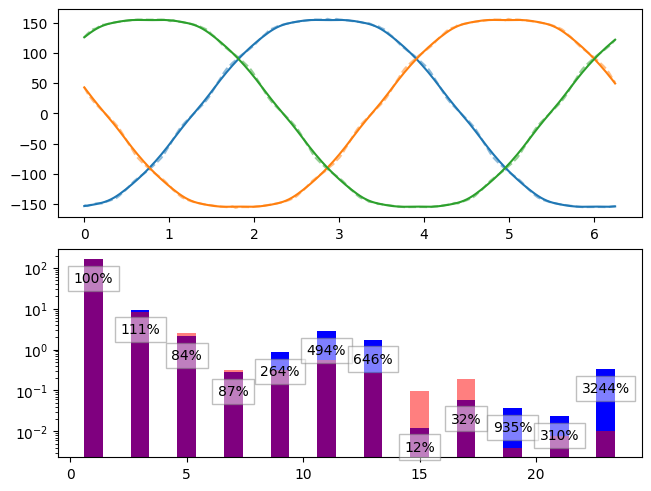

In [117]:
theta_err = np.pi+0.0129

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
la, = ax_t.plot(j1_df['angles'], j1_df['Back_EMF_0'], '--', alpha=0.5)
lb, = ax_t.plot(j1_df['angles'], j1_df['Back_EMF_1'], '--', alpha=0.5)
lc, = ax_t.plot(j1_df['angles'], j1_df['Back_EMF_2'], '--', alpha=0.5)
ax_t.plot(j1_df['angles'], predict(res.x, j1_df['angles']/num_pole_pairs+theta_err), color=la.get_color())
ax_t.plot(j1_df['angles'], predict(res.x, j1_df['angles']/num_pole_pairs-(2*np.pi/num_pole_pairs/num_phases)+theta_err), color=lb.get_color())
ax_t.plot(j1_df['angles'], predict(res.x, j1_df['angles']/num_pole_pairs+(2*np.pi/num_pole_pairs/num_phases)+theta_err), color=lc.get_color())

err = np.sum(np.abs(j1_df['Back_EMF_0'] - predict(res.x, j1_df['angles']/num_pole_pairs+theta_err)))
print(f"Error {err}")

# do an fft of the j1_df['Back_EMF_0'] and compare to the coefficients
from scipy.fft import fft
# Number of sample points
N = len(j1_df['Back_EMF_0'])
# sample spacing
delta_theta = np.diff(j1_df['angles'])[0]

yf = fft(j1_df['Back_EMF_0'].values, n=N)
ax_w.bar(x=range(1,24,2), height=np.abs(yf[1:24:2])/(N/2), color='b')
ax_w.bar(n_idx, abs(res.x[1:]), color = 'r', alpha=0.5)
ax_w.set_yscale('log')
for i in range(1, len(res.x)):
    diff = abs(yf[i*2-1]/(N/2)) / abs(res.x[i])
    ax_w.text(n_idx[i-1], abs(yf[i*2-1]/(N/2))*0.5, f"{diff:2.0%}", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))

In [114]:
current_df = pd.read_csv(os.path.join(machine, op_point, "CurrentAngle.csv"),
                         index_col=None, header=[0,1])
current_df

EMFa                  EMFb                 EMFc              \
            X           Y         X          Y         X           Y   
0    2.551802  149.066872  2.333041 -15.634979  2.551802 -141.281893   
1    3.452581  146.192901  3.043136  -7.469229  3.452581 -145.942387   
2    4.353360  141.377058  3.695648   1.087563  4.353360 -148.971708   
3    5.254139  135.629115  4.276150   9.321965  5.254139 -151.612654   
4    6.097726  127.231596  4.852006  18.048740  6.154918 -153.321502   
..        ...         ...       ...        ...       ...         ...   
102       NaN         NaN       NaN        NaN       NaN         NaN   
103       NaN         NaN       NaN        NaN       NaN         NaN   
104       NaN         NaN       NaN        NaN       NaN         NaN   
105       NaN         NaN       NaN        NaN       NaN         NaN   
106       NaN         NaN       NaN        NaN       NaN         NaN   

         EMFb2                     Ib            
             X           Y          X         Y  
0     2.358823  -16.036272   2.446874 -0.984369  
1     3.072530   -9.178278   3.088776  0.054222  
2     3.607810   -1.276844   3.613129  1.184830  
3     4.190671    6.353062   4.181068  2.195513  
4     4.678370   12.887810   4.682967  3.281621  
..         ...         ...        ...       ...  
102  66.873734 -122.071517  70.656314 -8.341240  
103  27.819041  146.239211  71.224253 -7.398438  
104  30.627954  122.071517  71.726152 -6.365127  
105        NaN         NaN  72.262722 -5.462866  
106        NaN         NaN  72.782782 -4.410699  

[107 rows x 10 columns]

In [115]:
current_coef = np.array([1.5, 75]) #initial guess offset and amplitude
bounds = [(None, None) for _ in range(len(current_coef))]



def predict_current(coefs, theta, num_pole_pairs=5):
    pred = coefs[1] * np.cos(coefs[0] - (theta * num_pole_pairs))
    return pred

def loss_current(coefs, theta, current):
    current_b = predict_current(coefs, theta)
    return np.sum((current - current_b)**2)

res_current = minimize(loss_current, current_coef,
                       args=(np.deg2rad(current_df['Ib']['X']),
                             current_df['Ib']['Y']),
                             method='Nelder-Mead',
                             tol=1e-6,
                             bounds=bounds,)
print(res_current)

ib_mag = res_current.x[1]
phase_current_b = (res_current.x[0])/num_pole_pairs
print(phase_current_b)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.134872304365305
             x: [ 1.831e+00  2.251e+01]
           nit: 66
          nfev: 125
 final_simplex: (array([[ 1.831e+00,  2.251e+01],
                       [ 1.831e+00,  2.251e+01],
                       [ 1.831e+00,  2.251e+01]]), array([ 1.135e+00,  1.135e+00,  1.135e+00]))
0.36619754023966233


NameError: name 'new_df' is not defined

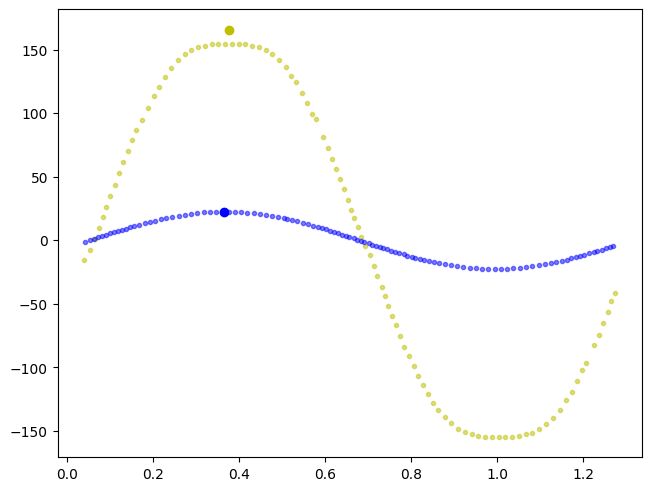

In [116]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.deg2rad(current_df['EMFb']['X']),
          current_df['EMFb']['Y'], 'y.', alpha=0.5)
ax_t.plot(np.deg2rad(current_df['Ib']['X']),
          current_df['Ib']['Y'], 'b.', alpha=0.5)

ax_t.plot(phase_emf_b, res.x[1], 'yo')
ax_t.plot(phase_current_b, ib_mag, 'bo')
ax_t.plot(new_df['theta'], new_df['emf b'], 'y-')
ax_t.plot(new_df['theta'], predict_current(res_current.x, new_df['theta'].pint.magnitude), 'b-')

In [ ]:
torque_df = pd.read_csv(os.path.join('M2', op_point, 'Torque.csv'),
                         index_col=None, header=[0,1])
torque_df

In [ ]:
arg_idx = np.argsort(np.deg2rad(torque_df['Torque']['X'])%(np.pi/5/3))

In [ ]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3),
          torque_df['Torque']['Y'][arg_idx], 'g-x', alpha=0.5)

In [ ]:
def torque_predict(coefs, theta, harm=[6, 12, 24, 30, 33, 36, 40, 43, 46], num_pole_pairs=5):
    pred = coefs[0] + np.matmul(coefs[2:], np.cos(np.outer(harm, (coefs[1]+theta))))
    return pred
def torque_loss(coefs, theta, torque):
    pred = torque_predict(coefs, theta)
    return np.sum((torque - pred)**2)


In [ ]:
torque_coefs = np.array([30, 0, 1,0,0, 0,0,0, 0,0,1])
test = torque_predict(torque_coefs, np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3))
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), test, 'r-')

In [ ]:

torque_coefs = np.array([30, 0, 1, -1, 1, 0, 0])
bounds = [(None, None) for _ in range(len(torque_coefs))]
bounds[0] = (28, 32)
res_torque = minimize(torque_loss, torque_coefs, args=(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3),
                             torque_df['Torque']['Y'][arg_idx]),
                             method='Nelder-Mead',
                             tol=1e-6,
                             bounds=bounds,
                             options={'disp': True, "maxiter":9000})
print(res_torque)

In [ ]:
test = torque_predict(res_torque.x, np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3))
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), test, 'r-')
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), torque_df['Torque']['Y'][arg_idx], 'g-x', alpha=0.5)

In [ ]:
#do a fft on the torque
from scipy.fft import fft
torque_fft = fft(torque_df['Torque']['Y'].values, n=torque_df['Torque']['Y'].size, )
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.abs(torque_fft[0:int(torque_df['Torque']['Y'].size/2)]), 'g-x', alpha=0.5)
ax_t.set_yscale('log')

In [ ]:
#detect the peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(np.abs(torque_fft[0:int(torque_df['Torque']['Y'].size/2)]), height=0.1)
peaks

In [ ]:
#make a copy of the fft with only the peaks
torque_fft_peaks = np.zeros_like(torque_fft)
torque_fft_peaks[peaks] = torque_fft[peaks]

In [ ]:
# produce a waveform from the ifft of the peaks and the phase

from scipy.fft import ifft
torque_waveform = ifft(torque_fft_peaks)
plt.plot(abs(torque_waveform))

In [ ]:
abs(ifft(torque_fft))